<a href="https://colab.research.google.com/github/wileyloyd/wileyloyd.github.io/blob/main/hospital_readmissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from pydoc import describe
from statistics import mean
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_auc_score, roc_curve, mean_squared_error, confusion_matrix
from matplotlib import pyplot as plt
import missingno as msno
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)

In [6]:
medical = pd.read_csv("/content/drive/MyDrive/OneDrive-Personal/wgu/D209 - Data Mining I/Task 1 - KNN/medical_clean.csv")


         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  50159.323900     38.751099    -91.243080    9965.253800   
std     2886.89568  27469.588208      5.403085     15.205998   14824.758614   
min        1.00000    610.000000     17.967190   -174.209700       0.000000   
25%     2500.75000  27592.000000     35.255120    -97.352982     694.750000   
50%     5000.50000  50207.000000     39.419355    -88.397230    2769.000000   
75%     7500.25000  72411.750000     42.044175    -80.438050   13945.000000   
max    10000.00000  99929.000000     70.560990    -65.290170  122814.000000   

           Children           Age         Income   VitD_levels    Doc_visits  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean       2.097200     53.511700   40490.495160     17.964262      5.012200   
std        2.163659     20.638538   28521.153293

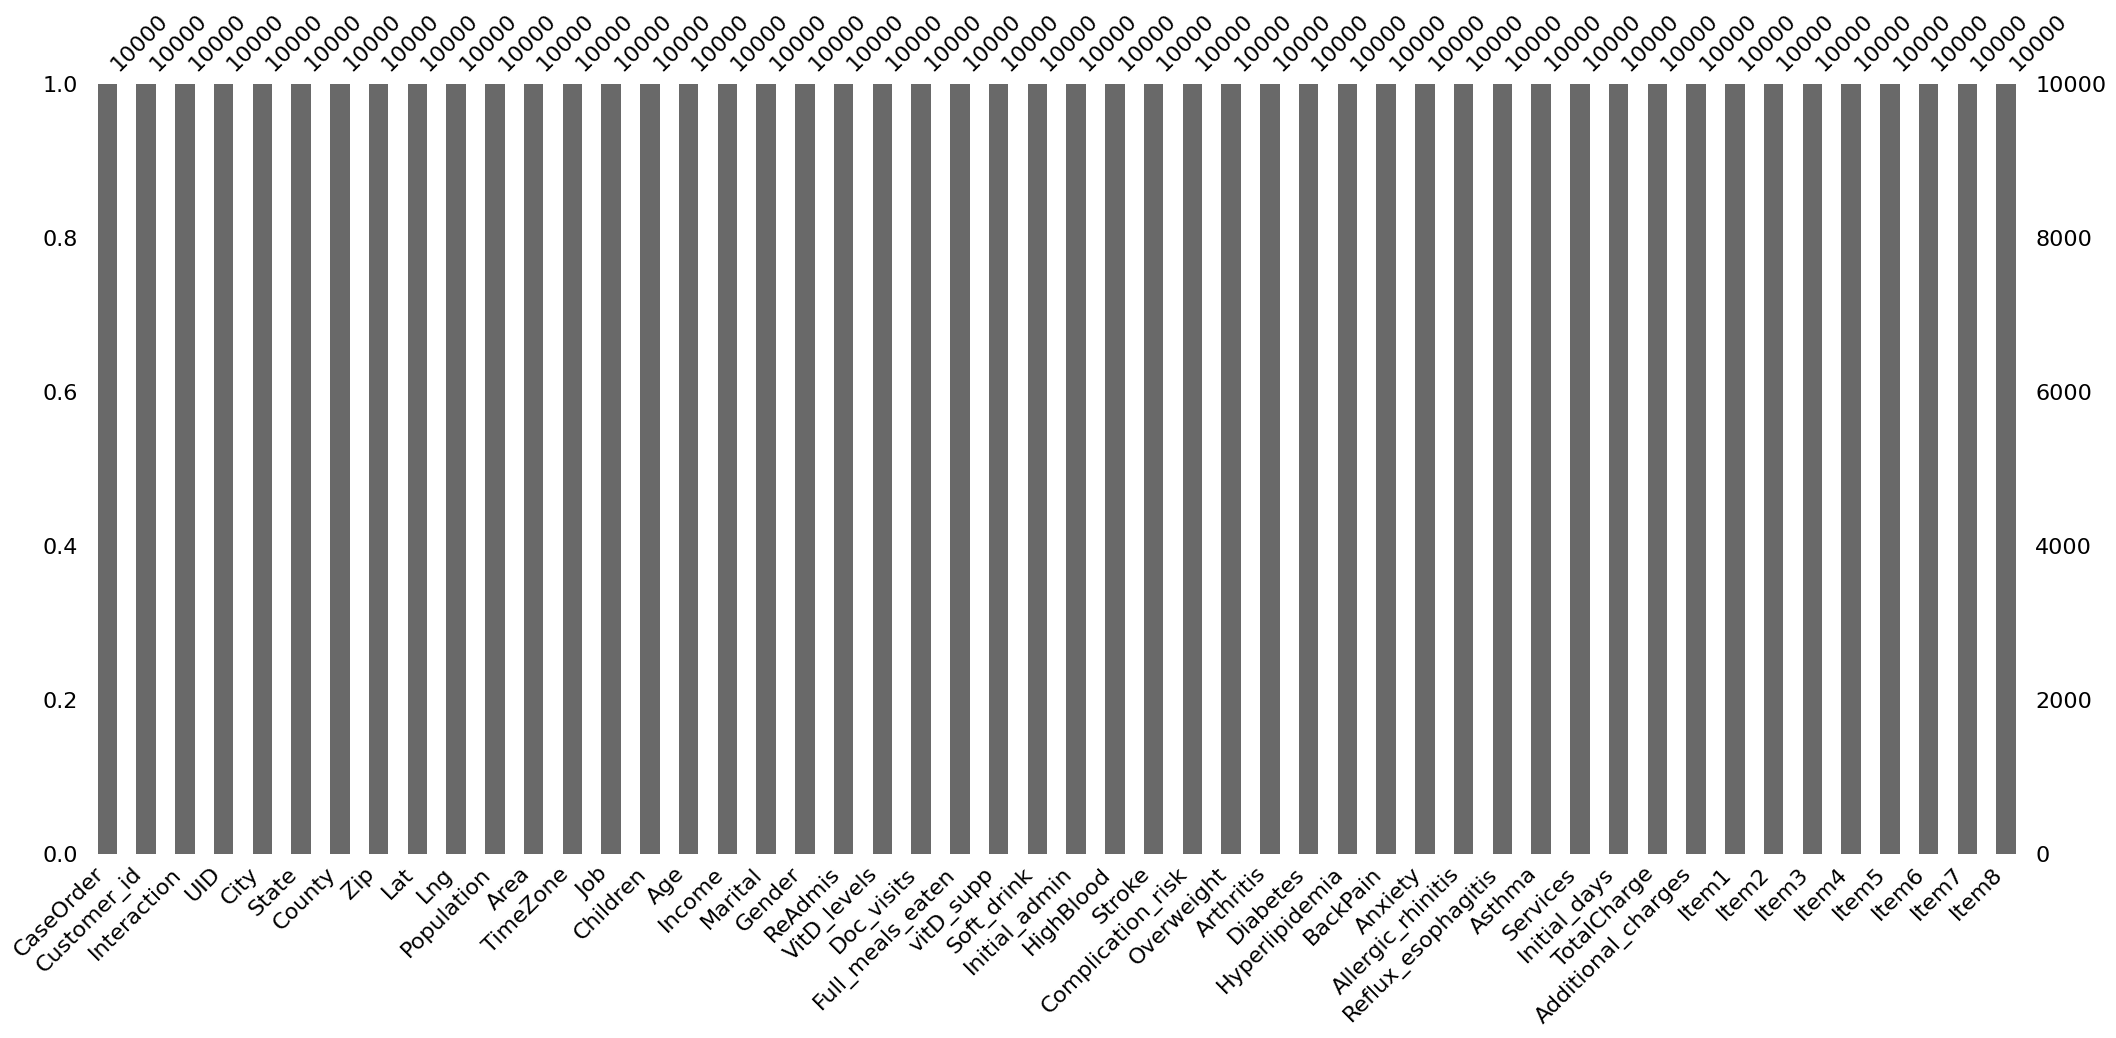

In [7]:
print(medical.describe())
print(medical.info())
print(msno.bar(medical))

In [8]:
describe_variables = ['TotalCharge', 'VitD_levels', 'Initial_days',
    'Children', 'Age', 'Income', 'Doc_visits']

val_counts_variables = ['ReAdmis','Complication_risk', 'Services', 'Marital', 'Gender',
    'Initial_admin', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes',
    'Hyperlipidemia','BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis',
    'Asthma', 'Children']

# Summary statistics and value counts of chosen features
for variable in describe_variables:
    print(medical[variable].describe())

for variable in val_counts_variables:
    print(medical[variable].value_counts())

count    10000.000000
mean      5312.172769
std       2180.393838
min       1938.312067
25%       3179.374015
50%       5213.952000
75%       7459.699750
max       9180.728000
Name: TotalCharge, dtype: float64
count    10000.000000
mean        17.964262
std          2.017231
min          9.806483
25%         16.626439
50%         17.951122
75%         19.347963
max         26.394449
Name: VitD_levels, dtype: float64
count    10000.000000
mean        34.455299
std         26.309341
min          1.001981
25%          7.896215
50%         35.836244
75%         61.161020
max         71.981490
Name: Initial_days, dtype: float64
count    10000.000000
mean         2.097200
std          2.163659
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: Children, dtype: float64
count    10000.000000
mean        53.511700
std         20.638538
min         18.000000
25%         36.000000
50%         53.000000
75%         71.000000
max     

In [9]:
# Identification of treatment of OUTLIERS using IQR
for variable in describe_variables:
    q1 = medical[variable].quantile(.25)
    q3 = medical[variable].quantile(.75)
    threshold = 1.5
    IQR = q3-q1
    tot_outliers = medical[variable][((medical[variable] < (q1 - threshold * IQR)) | (medical[variable] > (q3 + threshold * IQR)))].count()
    print(variable, ' Outliers Identified:', ' ', tot_outliers)
    medical = medical[~((medical[variable] < (q1 - threshold * IQR)) | (medical[variable] > (q3 + threshold * IQR)))]

# This prints the total amount of observations removed and the total observations remaining in the data set
print('Total Observations Removed: ', 10000 - medical.Customer_id.count())
print('Total Observations Remaining: ', medical.Customer_id.count())



TotalCharge  Outliers Identified:   0
VitD_levels  Outliers Identified:   60
Initial_days  Outliers Identified:   0
Children  Outliers Identified:   410
Age  Outliers Identified:   0
Income  Outliers Identified:   307
Doc_visits  Outliers Identified:   0
Total Observations Removed:  777
Total Observations Remaining:  9223


In [10]:
# This section uses one-hot encoding to create dummy variables for the regression model
dummies_readmis = pd.get_dummies(medical['ReAdmis'])
pd.DataFrame(dummies_readmis)
dummies_readmis = dummies_readmis.drop('No', axis=1)
dummies_readmis = dummies_readmis.rename(columns = {'Yes' : 'ReAdmis_Yes'})
medical = medical.join(dummies_readmis)

dummies_comp_risk = pd.get_dummies(medical['Complication_risk'])
pd.DataFrame(dummies_comp_risk)
dummies_comp_risk = dummies_comp_risk.drop('Low', axis=1)
dummies_comp_risk = dummies_comp_risk.rename(columns = {'Medium' : 'Comp_risk_Medium', 'High' : 'Comp_risk_High'})
medical = medical.join(dummies_comp_risk)

dummies_svs = pd.get_dummies(medical['Services'])
pd.DataFrame(dummies_svs)
dummies_svs = dummies_svs.drop('MRI', axis=1)
dummies_svs = dummies_svs.rename(columns = {'Blood Work' : 'Services_Blood_Work', 'Intravenous' : 'Services_Intravenous', 'CT Scan' : 'Services_CT_Scan'})
medical = medical.join(dummies_svs)

dummies_marital = pd.get_dummies(medical['Marital'])
pd.DataFrame(dummies_marital)
dummies_marital = dummies_marital.drop('Separated', axis=1)
dummies_marital = dummies_marital.rename(columns = {'Divorced' : 'Marital_Divorced', 'Married' : 'Marital_Married', 'Widowed' : 'Marital_Widowed', 'Never Married' : 'Marital_Never_Married'})
medical = medical.join(dummies_marital)

dummies_initial_admin = pd.get_dummies(medical['Initial_admin'])
pd.DataFrame(dummies_initial_admin)
dummies_initial_admin = dummies_initial_admin.drop('Observation Admission', axis=1)
dummies_initial_admin = dummies_initial_admin.rename(columns = {'Elective Admission':'Initial_admin_Elective_Admission', 'Emergency Admission':'Initial_admin_Emergency_Admission'})
medical = medical.join(dummies_initial_admin)

dummies_gender_female = pd.get_dummies(medical['Gender'])
pd.DataFrame(dummies_gender_female)
dummies_gender_female = dummies_gender_female.drop('Male', axis=1)
medical = medical.join(dummies_gender_female)

dummies_high_blood_pressure = pd.get_dummies(medical['HighBlood'])
pd.DataFrame(dummies_high_blood_pressure)
dummies_high_blood_pressure = dummies_high_blood_pressure.drop('No', axis=1)
dummies_high_blood_pressure = dummies_high_blood_pressure.rename(columns = {'Yes' : 'HighBlood_Yes'})
medical = medical.join(dummies_high_blood_pressure)

dummies_stroke = pd.get_dummies(medical['Stroke'])
pd.DataFrame(dummies_stroke)
dummies_stroke = dummies_stroke.drop('No', axis=1)
dummies_stroke = dummies_stroke.rename(columns = {'Yes' : 'Stroke_Yes'})
medical = medical.join(dummies_stroke)

dummies_overweight = pd.get_dummies(medical['Overweight'])
pd.DataFrame(dummies_overweight)
dummies_overweight = dummies_overweight.drop('No', axis=1)
dummies_overweight = dummies_overweight.rename(columns = {'Yes' : 'Overweight_Yes'})
medical = medical.join(dummies_overweight)

dummies_arthritis = pd.get_dummies(medical['Arthritis'])
pd.DataFrame(dummies_arthritis)
dummies_arthritis = dummies_arthritis.drop('No', axis=1)
dummies_arthritis = dummies_arthritis.rename(columns = {'Yes' : 'Arthritis_Yes'})
medical = medical.join(dummies_arthritis)

dummies_diabetes = pd.get_dummies(medical['Diabetes'])
pd.DataFrame(dummies_diabetes)
dummies_diabetes = dummies_diabetes.drop('No', axis=1)
dummies_diabetes = dummies_diabetes.rename(columns= {'Yes' : 'Diabetes_Yes'})
medical = medical.join(dummies_diabetes)

dummies_hyperlipidemia = pd.get_dummies(medical['Hyperlipidemia'])
pd.DataFrame(dummies_hyperlipidemia)
dummies_hyperlipidemia = dummies_hyperlipidemia.drop('No', axis=1)
dummies_hyperlipidemia = dummies_hyperlipidemia.rename(columns={'Yes' : 'Hyperlipidemia_Yes'})
medical = medical.join(dummies_hyperlipidemia)

dummies_backpain = pd.get_dummies(medical['BackPain'])
pd.DataFrame(dummies_backpain)
dummies_backpain = dummies_backpain.drop('No', axis=1)
dummies_backpain = dummies_backpain.rename(columns={'Yes' : 'BackPain_Yes'})
medical = medical.join(dummies_backpain)

dummies_anxiety = pd.get_dummies(medical['Anxiety'])
pd.DataFrame(dummies_anxiety)
dummies_anxiety = dummies_anxiety.drop('No', axis=1)
dummies_anxiety = dummies_anxiety.rename(columns={'Yes' : 'Anxiety_Yes'})
medical = medical.join(dummies_anxiety)

dummies_allergic_rhinitis = pd.get_dummies(medical['Allergic_rhinitis'])
pd.DataFrame(dummies_allergic_rhinitis)
dummies_allergic_rhinitis = dummies_allergic_rhinitis.drop('No', axis=1)
dummies_allergic_rhinitis = dummies_allergic_rhinitis.rename(columns={'Yes' : 'Alleric_rhinitis_Yes'})
medical = medical.join(dummies_allergic_rhinitis)

dummies_reflux = pd.get_dummies(medical['Reflux_esophagitis'])
pd.DataFrame(dummies_reflux)
dummies_reflux = dummies_reflux.drop('No', axis=1)
dummies_reflux = dummies_reflux.rename(columns={'Yes' : 'Reflux_esophagitis_Yes'})
medical = medical.join(dummies_reflux)

dummies_asthma = pd.get_dummies(medical['Asthma'])
pd.DataFrame(dummies_asthma)
dummies_asthma = dummies_asthma.drop('No', axis=1)
dummies_asthma = dummies_asthma.rename(columns={'Yes' : 'Asthma_Yes'})
medical = medical.join(dummies_asthma)


In [11]:
# This section of code selects the best features for the KNN model.
drop = ["CaseOrder", "Customer_id", "Interaction", "UID", "Lat", "Lng", "TimeZone", "ReAdmis", "ReAdmis_Yes", "City", "State", "County", "Zip", "Area", "Population", "Job", "Complication_risk", "Services", \
    "Marital", "Initial_admin", "Gender", "HighBlood", "Stroke", "Overweight", "Arthritis", "Diabetes", "Hyperlipidemia", "BackPain", \
        "Anxiety", "Allergic_rhinitis", "Reflux_esophagitis", "Asthma", "Soft_drink"]

X = medical.drop(drop, 1)
y = medical["ReAdmis_Yes"]

print(X.shape, y.shape)


(9223, 42) (9223,)


<ipython-input-11-15a059ed15f9>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = medical.drop(drop, 1)


In [12]:
features = X.columns
skbest = SelectKBest(score_func= f_classif, k="all")
X_new = skbest.fit_transform(X,y)
p_vals = pd.DataFrame({"Features" : features, "p_value" : skbest.pvalues_}).sort_values("p_value")
keep_features = p_vals[p_vals["p_value"] < 0.05]["Features"]

print(keep_features)

8              TotalCharge
7             Initial_days
21        Services_CT_Scan
0                 Children
22    Services_Intravenous
Name: Features, dtype: object


In [13]:
# Checks for colliniarity between explanatory variables.
print("TotalCharge by Initial_days: ", pearsonr(medical.TotalCharge, medical.Initial_days))
print("TotalCharge by Children: ", pearsonr(medical.TotalCharge, medical.Children))
print("Initial_days by Children: ", pearsonr(medical.Initial_days, medical.Children))


TotalCharge by Initial_days:  PearsonRResult(statistic=0.9876067493206067, pvalue=0.0)
TotalCharge by Children:  PearsonRResult(statistic=0.018109264599204485, pvalue=0.082024846159527)
Initial_days by Children:  PearsonRResult(statistic=0.018051835990484665, pvalue=0.0829996391390297)


In [14]:
# Droped correlated features
X = medical[["Initial_days", "Children"]]
features = X.columns
X_new = skbest.fit_transform(X, y)
p_vals = pd.DataFrame({"Features" : features, "p_value" : skbest.pvalues_}).sort_values("p_value")
keep_features = p_vals[p_vals["p_value"] < 0.05]["Features"]

print(keep_features)


0    Initial_days
1        Children
Name: Features, dtype: object


In [15]:
X = medical[keep_features]
y = medical["ReAdmis_Yes"]


In [16]:
# Preparing to create the model.

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=888)

# Create the steps for the pipeline
steps = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {"knn__n_neighbors" : np.arange(1, 50)}

cross_val = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, cv=10)
cross_val.fit(X_train, y_train)

y_pred = cross_val.predict(X_test)


In [17]:
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))

print("Best Estimator: ", cross_val.best_estimator_)
print("Best Parameters: ", cross_val.best_params_)
print("Best Score: ", cross_val.best_score_)

print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))


Mean Absolute Error:  2.7739837398373983
Mean Squared Error:  0.020596205962059622
Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=23))])
Best Parameters:  {'knn__n_neighbors': 23}
Best Score:  0.9761442234503755
Confusion Matrix:  [[1149   18]
 [  20  658]]


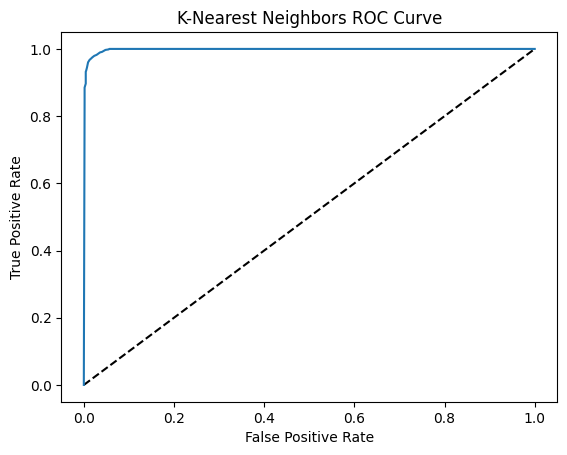

AUC:  0.9977402158169726


In [18]:
y_pred_proba = cross_val.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label = "K-Nearest Neighbors")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("K-Nearest Neighbors ROC Curve")
plt.show()

print("AUC: ", roc_auc_score(y_test, y_pred_proba))


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] 
 {1: 1.0, 2: 0.9821089726213066, 3: 0.9822445107075088, 4: 0.9789915966386554, 5: 0.9795337489834643, 6: 0.9791271347248577, 7: 0.978720520466251, 8: 0.9783139062076444, 9: 0.977500677690431, 10: 0.9776362157766333, 11: 0.9772296015180265, 12: 0.9773651396042288, 13: 0.9772296015180265, 14: 0.9768229872594199, 15: 0.9769585253456221, 16: 0.9773651396042288, 17: 0.9773651396042288, 18: 0.977500677690431, 19: 0.9777717538628354, 20: 0.9770940634318244, 21: 0.9776362157766333, 22: 0.9772296015180265, 23: 0.9779072919490377, 24: 0.9776362157766333, 25: 0.9773651396042288, 26: 0.977500677690431, 27: 0.9781783681214421, 28: 0.9779072919490377, 29: 0.9779072919490377, 30: 0.9779072919490377, 31: 0.9779072919490377, 32: 0.9779072919490377, 33: 0.9777717538628354, 34: 0.9776362157766333, 35: 0.9773651396042288, 36: 0.9776362157766333, 37: 0.9768

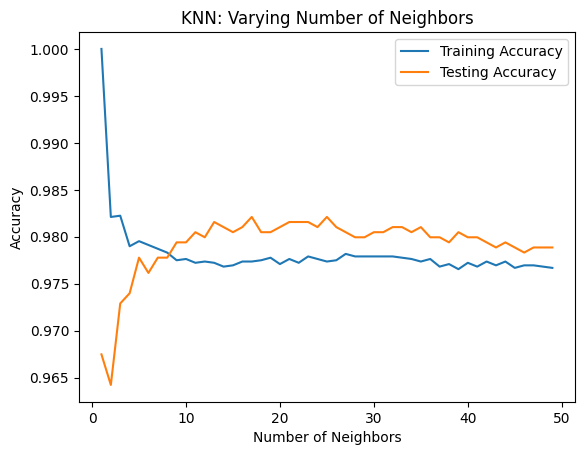

In [19]:
n_neighbors = np.arange(1,50)

train_accuracies = {}
test_accuracies = {}

for neighbor in n_neighbors:

	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1)

	# Fit the model
	knn.fit(X_train, y_train)

	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)
print(n_neighbors, '\n', train_accuracies, '\n', test_accuracies)


plt.title("KNN: Varying Number of Neighbors")
plt.plot(n_neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(n_neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# NOTE End Datacamp

# Comparing training and testing accuracies
print("Training Accuracy: ", cross_val.score(X_train, y_train))
print("Testing Accuracy: ", cross_val.score(X_test, y_test))
